In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Loading the data

In [2]:
recovered = pd.read_csv('./DATASETS/COVID-Time Series Data - Refined/recovered.csv')

recovered = recovered.melt(['State', 'Country'], recovered.columns[4:], var_name='Dates', value_name='Recovered')
recovered.Dates = pd.to_datetime(recovered.Dates)

recovered.head()

,State,Country,Dates,Recovered
0,NaN,Afghanistan,2020-01-22,0
1,NaN,Albania,2020-01-22,0
2,NaN,Algeria,2020-01-22,0
3,NaN,Andorra,2020-01-22,0
4,NaN,Angola,2020-01-22,0


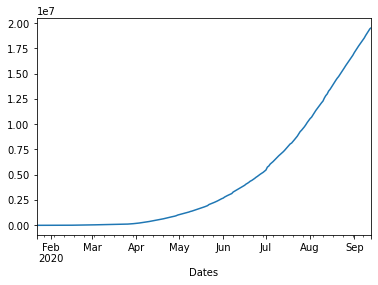

In [3]:
days = recovered.groupby('Dates').sum()
days.Recovered.resample('d').sum().plot();

In [4]:
days.head()

,Recovered
Dates,
2020-01-22,28
2020-01-23,30
2020-01-24,36
2020-01-25,39
2020-01-26,52


In [5]:
days.tail()

,Recovered
Dates,
2020-09-09,18776723
2020-09-10,18992383
2020-09-11,19215800
2020-09-12,19439157
2020-09-13,19547423


In [6]:
len(days)

236

# 2. Preparing the data for the LSTM model

In [7]:
# number of data in the test set
test_size = 30
test_ind = len(days) - test_size

train = days.iloc[:test_ind,:]
test = days.iloc[test_ind:,:]

In [8]:
from sklearn.preprocessing import MinMaxScaler

# The data is scaled
scaler = MinMaxScaler(feature_range=(0,10))

scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [9]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# batch size should be less than len(test)
BS = 15

generator = TimeseriesGenerator(scaled_train, scaled_train, length=BS, batch_size=1)

In [10]:
x1, y1 = generator[0]
x2, y2 = generator[1]

In [11]:
# given data of last BS days it will predict the expected number of cases for the (BS+1)th day

print(f'example 1: {x1}\n{y1}\n\n\nexample 2: {x2}\n{y2}')

example 1: [[[0.00000000e+00]
  [1.50638674e-06]
  [6.02554696e-06]
  [8.28512707e-06]
  [1.80766409e-05]
  [2.48553812e-05]
  [5.95022763e-05]
  [7.38129503e-05]
  [8.66172376e-05]
  [1.46119514e-04]
  [1.92817503e-04]
  [3.34417856e-04]
  [4.48150055e-04]
  [6.20631337e-04]
  [8.25499934e-04]]]
[[0.00109891]]


example 2: [[[1.50638674e-06]
  [6.02554696e-06]
  [8.28512707e-06]
  [1.80766409e-05]
  [2.48553812e-05]
  [5.95022763e-05]
  [7.38129503e-05]
  [8.66172376e-05]
  [1.46119514e-04]
  [1.92817503e-04]
  [3.34417856e-04]
  [4.48150055e-04]
  [6.20631337e-04]
  [8.25499934e-04]
  [1.09890913e-03]]]
[[0.00149358]]


In [12]:
valGenerator = TimeseriesGenerator(scaled_test, scaled_test, length=BS, batch_size=1)

# 3. Building and compiling the model

In [13]:
# part 1: Building the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.regularizers import l1

n_features = 1
model = Sequential()

# a. input layer
model.add(LSTM(58, activation=None, input_shape=(BS, n_features)))

# b. hidden layers
# model.add(Dense(18, activation='relu', kernel_regularizer=l1()))

# c. final layer
model.add(Dense(1))


# part 2: compiling the model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(), loss='mse')

print(model.summary())

# part 3: training the model
EPOCHS = 14

# Without early stopping

# """

H = model.fit_generator(generator, epochs=EPOCHS, validation_data=valGenerator)

# """

# With early stopping
"""

from tensorflow.keras.callbacks import EarlyStopping
earlyStop = EarlyStopping(monitor='val_loss', patience=4)
H = model.fit_generator(generator, epochs=EPOCHS, validation_data=valGenerator, callbacks=[earlyStop])


"""

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 58)                13920     
_________________________________________________________________
dense (Dense)                (None, 1)                 59        
Total params: 13,979
Trainable params: 13,979
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/14
191/191 [==============================] - 5s 26ms/step - loss: 15.2675 - val_loss: 1.3111
Epoch 2/14
191/191 [==============================] - 5s 25ms/step - loss: 0.1849 - val_loss: 9.2816
Epoch 3/14
191/191 [==============================] - 5s 25ms/step - loss: 0.0537 - val_loss: 3.0018
Epoch 4/14
191/191 [==============================] - 5s 25ms/step - loss: 0.0300 - val_loss: 0.7319
Epoch 5/14
191/191 [==============================] - 5s 25ms/step - loss: 0.0201 - val_loss: 0.1422
Epo

"\n\nfrom tensorflow.keras.callbacks import EarlyStopping\nearlyStop = EarlyStopping(monitor='val_loss', patience=4)\nH = model.fit_generator(generator, epochs=EPOCHS, validation_data=valGenerator, callbacks=[earlyStop])\n\n\n"

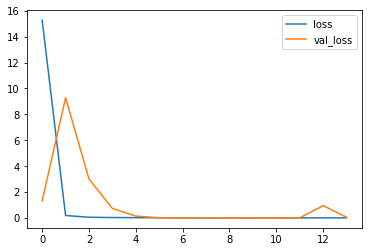

In [14]:
losses = pd.DataFrame(H.history)
losses.plot();

# 4. Evaluating the model

In [15]:
# last 12 rows from scaled_train
first_eval_batch = scaled_train[-BS:]
print(first_eval_batch)

[[ 7.80994642]
 [ 7.94886917]
 [ 8.05203406]
 [ 8.21957816]
 [ 8.38658749]
 [ 8.55344995]
 [ 8.6958984 ]
 [ 8.84090771]
 [ 8.99243666]
 [ 9.12553798]
 [ 9.24958516]
 [ 9.47927374]
 [ 9.66105093]
 [ 9.78559974]
 [10.        ]]


In [16]:
# array to store the forcasted results
test_predictions = []

current_batch = first_eval_batch.reshape((1, BS, n_features))

count=1

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    
    print(f'Result {count}:')
    print(f'current batch:\n{current_batch},\n prediction: {current_pred}')
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    count += 1

    print('\n\n')

Result 1:
current batch:
[[[ 7.80994642]
  [ 7.94886917]
  [ 8.05203406]
  [ 8.21957816]
  [ 8.38658749]
  [ 8.55344995]
  [ 8.6958984 ]
  [ 8.84090771]
  [ 8.99243666]
  [ 9.12553798]
  [ 9.24958516]
  [ 9.47927374]
  [ 9.66105093]
  [ 9.78559974]
  [10.        ]]],
 prediction: [10.050682]



Result 2:
current batch:
[[[ 7.94886917]
  [ 8.05203406]
  [ 8.21957816]
  [ 8.38658749]
  [ 8.55344995]
  [ 8.6958984 ]
  [ 8.84090771]
  [ 8.99243666]
  [ 9.12553798]
  [ 9.24958516]
  [ 9.47927374]
  [ 9.66105093]
  [ 9.78559974]
  [10.        ]
  [10.05068207]]],
 prediction: [10.201478]



Result 3:
current batch:
[[[ 8.05203406]
  [ 8.21957816]
  [ 8.38658749]
  [ 8.55344995]
  [ 8.6958984 ]
  [ 8.84090771]
  [ 8.99243666]
  [ 9.12553798]
  [ 9.24958516]
  [ 9.47927374]
  [ 9.66105093]
  [ 9.78559974]
  [10.        ]
  [10.05068207]
  [10.201478  ]]],
 prediction: [10.346335]



Result 4:
current batch:
[[[ 8.21957816]
  [ 8.38658749]
  [ 8.55344995]
  [ 8.6958984 ]
  [ 8.84090771]
  [ 8.9

In [17]:
true_predictions = scaler.inverse_transform(test_predictions)
print(true_predictions)

[[13344120.58307571]
 [13544329.37739897]
 [13736653.7024724 ]
 [13929790.91164064]
 [14120251.42769918]
 [14308244.16945743]
 [14493956.53075657]
 [14678309.02053261]
 [14861183.88454752]
 [15042336.75110302]
 [15222277.88856392]
 [15401128.84969206]
 [15575960.97263183]
 [15748455.73725538]
 [15920188.26476822]
 [16088822.46302872]
 [16258835.52543135]
 [16427308.91951733]
 [16594631.36088962]
 [16760759.79961176]
 [16925817.05462017]
 [17089889.22578783]
 [17253063.67916231]
 [17415398.65877533]
 [17576956.20718241]
 [17737788.23754225]
 [17897947.92918815]
 [18057488.46145344]
 [18216506.06360788]
 [18375061.51203241]]


In [18]:
test['Predictions'] = true_predictions.astype(int)
test

C:\Users\Python\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Recovered,Predictions
Dates,,
2020-08-15,13445842,13344120
2020-08-16,13676868,13544329
2020-08-17,13888301,13736653
2020-08-18,14116451,13929790
2020-08-19,14333914,14120251
2020-08-20,14541573,14308244
2020-08-21,14712252,14493956
2020-08-22,14922177,14678309
2020-08-23,15137610,14861183


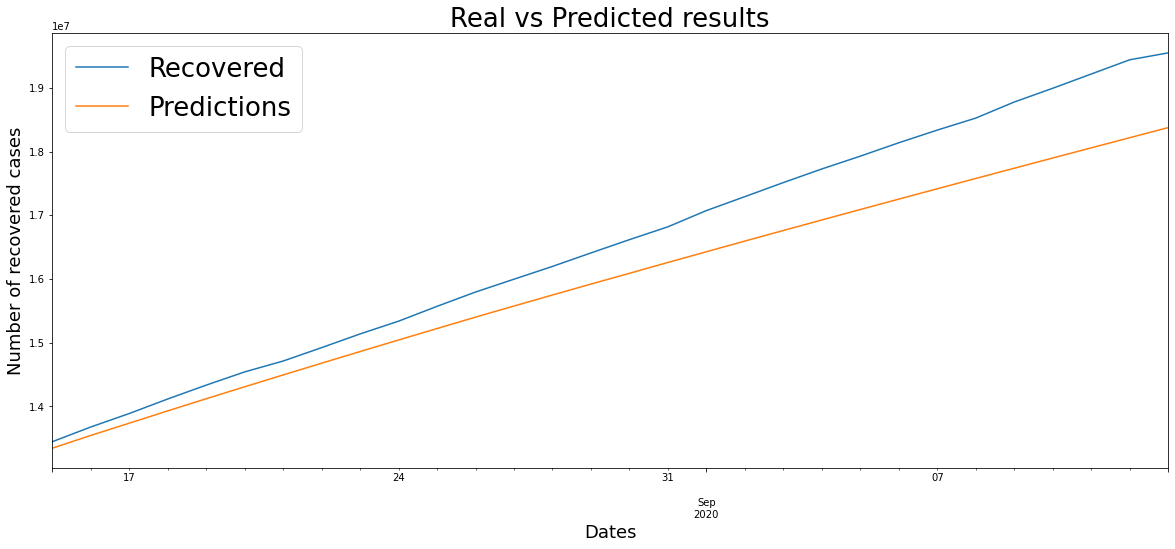

In [19]:
test.plot(figsize=(20,8));
plt.title('Real vs Predicted results', fontsize=26)
plt.xlabel('Dates', fontsize=18)
plt.ylabel('Number of recovered cases', fontsize=18)
plt.legend(loc=2, prop={'size': 26})

In [20]:
from sklearn.metrics import r2_score, mean_squared_error

mse = mean_squared_error(test.Recovered, test.Predictions)
length = len(test)
rmse = np.sqrt(mse/length)

r2s = r2_score(test.Recovered, test.Predictions) 

print(f'RMSE = {rmse}; r2 score = {r2s}')

RMSE = 123682.2946580741; r2 score = 0.8642036977991414


# 5. Forecasting the number of confirmed cases for the next N days

In [21]:
from pandas.tseries.offsets import DateOffset

ndays=60
last_date = days.index[-1]
future_dates = [last_date+DateOffset(days=x) for x in range(1, ndays+1)]

In [22]:
days_copy = days.copy()
days_copy.tail()

,Recovered
Dates,
2020-09-09,18776723
2020-09-10,18992383
2020-09-11,19215800
2020-09-12,19439157
2020-09-13,19547423


In [23]:
# get the scaled data for the last BS days in our dataset
last_index = len(days)
last_n_days = scaler.transform(days_copy.iloc[-BS:last_index,:])
last_n_days

array([[12.51578938],
       [12.66751341],
       [12.85942708],
       [13.02410377],
       [13.19034183],
       [13.35133767],
       [13.50262333],
       [13.66088056],
       [13.81061691],
       [13.9524274 ],
       [14.14248219],
       [14.30491587],
       [14.47319208],
       [14.64142309],
       [14.72296832]])

In [24]:
# array to store the forcasted results for the next ndays
test_predictions_ndays = []

current_batch = last_n_days.reshape((1, BS, n_features))

count=1

for i in range(ndays):
    
    current_pred = model.predict(current_batch)[0]
    test_predictions_ndays.append(current_pred) 
    
    print(f'Result {count}:')
    print(f'current batch:\n{current_batch},\n prediction: {current_pred}')
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    count += 1

    print('\n\n')

Result 1:
current batch:
[[[12.51578938]
  [12.66751341]
  [12.85942708]
  [13.02410377]
  [13.19034183]
  [13.35133767]
  [13.50262333]
  [13.66088056]
  [13.81061691]
  [13.9524274 ]
  [14.14248219]
  [14.30491587]
  [14.47319208]
  [14.64142309]
  [14.72296832]]],
 prediction: [14.68949]



Result 2:
current batch:
[[[12.66751341]
  [12.85942708]
  [13.02410377]
  [13.19034183]
  [13.35133767]
  [13.50262333]
  [13.66088056]
  [13.81061691]
  [13.9524274 ]
  [14.14248219]
  [14.30491587]
  [14.47319208]
  [14.64142309]
  [14.72296832]
  [14.68949032]]],
 prediction: [14.819517]



Result 3:
current batch:
[[[12.85942708]
  [13.02410377]
  [13.19034183]
  [13.35133767]
  [13.50262333]
  [13.66088056]
  [13.81061691]
  [13.9524274 ]
  [14.14248219]
  [14.30491587]
  [14.47319208]
  [14.64142309]
  [14.72296832]
  [14.68949032]
  [14.81951714]]],
 prediction: [14.943312]



Result 4:
current batch:
[[[13.02410377]
  [13.19034183]
  [13.35133767]
  [13.50262333]
  [13.66088056]
  [13.81

current batch:
[[[16.47576714]
  [16.59095383]
  [16.70552444]
  [16.8195858 ]
  [16.9329586 ]
  [17.04567146]
  [17.15781593]
  [17.26945114]
  [17.38056755]
  [17.49113083]
  [17.60109138]
  [17.71042442]
  [17.81910324]
  [17.92710304]
  [18.03441238]]],
 prediction: [18.14102]



Result 32:
current batch:
[[[16.59095383]
  [16.70552444]
  [16.8195858 ]
  [16.9329586 ]
  [17.04567146]
  [17.15781593]
  [17.26945114]
  [17.38056755]
  [17.49113083]
  [17.60109138]
  [17.71042442]
  [17.81910324]
  [17.92710304]
  [18.03441238]
  [18.14101982]]],
 prediction: [18.246832]



Result 33:
current batch:
[[[16.70552444]
  [16.8195858 ]
  [16.9329586 ]
  [17.04567146]
  [17.15781593]
  [17.26945114]
  [17.38056755]
  [17.49113083]
  [17.60109138]
  [17.71042442]
  [17.81910324]
  [17.92710304]
  [18.03441238]
  [18.14101982]
  [18.24683189]]],
 prediction: [18.351828]



Result 34:
current batch:
[[[16.8195858 ]
  [16.9329586 ]
  [17.04567146]
  [17.15781593]
  [17.26945114]
  [17.38056755]

In [25]:
true_predictions_ndays = scaler.inverse_transform(test_predictions_ndays).astype(int)
future_dates_df = pd.DataFrame(index=future_dates[:],columns=days.columns, data=true_predictions_ndays)
future_df = pd.concat([days_copy,future_dates_df])

In [26]:
future_df.head()

,Recovered
2020-01-22,28
2020-01-23,30
2020-01-24,36
2020-01-25,39
2020-01-26,52


In [27]:
future_df.tail()

,Recovered
2020-11-08,27198246
2020-11-09,27303075
2020-11-10,27406286
2020-11-11,27507894
2020-11-12,27607888


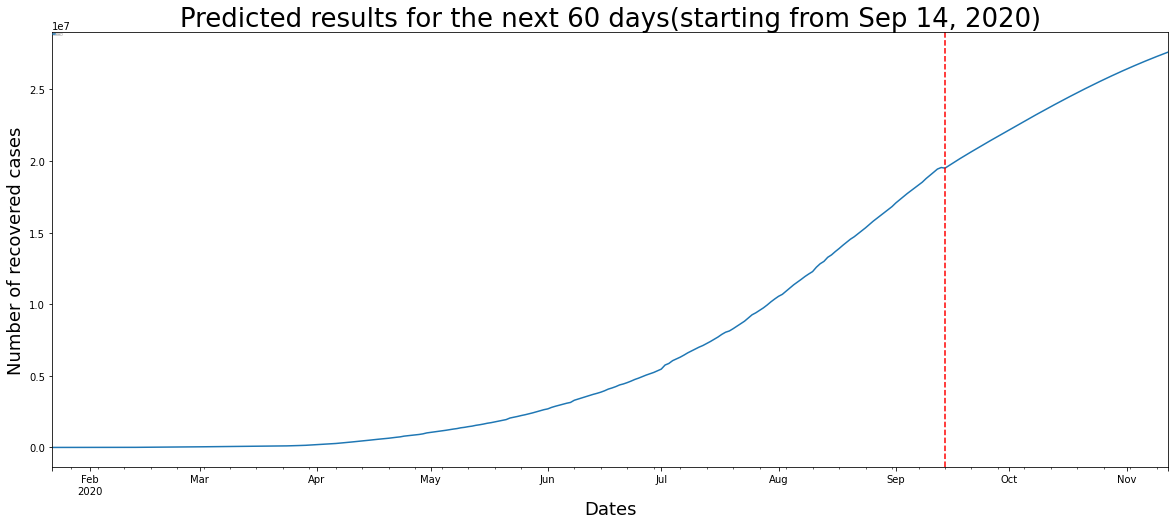

In [28]:
future_df.plot(figsize=(20,8));

plt.axvline("2020-09-14", color="red", linestyle="--");

plt.title(f'Predicted results for the next {ndays} days(starting from Sep 14, 2020)', fontsize=26);
plt.xlabel('Dates', fontsize=18);
plt.ylabel('Number of recovered cases', fontsize=18);
plt.legend(loc=2, prop={'size': 0});